In [3]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import os
import spotipy
from sklearn.manifold import TSNE
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import string
import re

In [4]:
load_dotenv()
SPOTIFY_KEY1 = os.getenv('SPOTIFY_KEY1')
SPOTIFY_KEY2 = os.getenv('SPOTIFY_KEY2')
SPOTIFY_DATA = os.getenv('SPOTIFY_DATA')
TCC_DATA = os.getenv('TCC_DATA')

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIFY_KEY1,
                                                                              SPOTIFY_KEY2))

In [6]:
def getid(artist_name, song_name):
    results = spotify.search(q="track" + song_name + "artist:" + artist_name, type="track", limit=1)

    if "tracks" in results and "items" in results["tracks"]:
        return results["tracks"]["items"][0]["id"]
    else:
        print("Track not found.")
        return None

In [7]:
def name_lookup(name, df):
    lookup = df[df['artist_name'].str.lower() == name.lower()]

    if not lookup.empty:
        return name
    else:
        print("Artist not found")
        return False

In [8]:
def song_lookup(song, df):
    lookup = df[df['track_name'].str.lower() == song.lower()]

    if not lookup.empty:
        return song
    else:
        print("Song not found.")
        return False

In [9]:
def print_info(track):
    print('\nArtist: ' + track['artists'][0]['name'])
    print('Track: ' + track['name'])
    print('Album: ' + track['album']['name'])
    print('Audio Preview: ' + track['preview_url'])
    print('Cover Art: ' + track['album']['images'][0]['url'])

In [10]:
def main():
    df = pd.read_csv(TCC_DATA)
    df.drop_duplicates(subset=['track_name'], keep='first', inplace=True)
    df.drop(columns=['release_date', 'lyrics'], axis=1, inplace=True)
    # print(df.columns)

    ''' Konrad --- testing if .env variables work, they do :)
    #               make sure your path variables are good if you run into any errors
    df_spotify = pd.read_csv(SPOTIFY_DATA)
    print(df_spotify.head(10))
    print(df_spotify.columns)
    '''

    '''Testing spotify api, works so far
    found = False
    while not found:
        artist_name = input("Enter artist name: ")
        if name_lookup(artist_name, df):
            found = True

    found = False
    while not found:
        song_name = input("Enter song name: ")
        if song_lookup(song_name, df):
            found = True

    track_id = getid(artist_name, song_name)

    track = spotify.track(track_id)
    print_info(track)
    '''

# Preprocessing the lyrics

    lyrics_df = pd.read_csv(TCC_DATA)
    lyrics_df = lyrics_df.iloc[:, [0,1,2,5,6]] 
    print(lyrics_df.columns)

    # checked the data and there are no nulls or duplicates

    # print(len(lyrics_df))
    # print(lyrics_df.isnull().sum())
    # print(lyrics_df)
    # print(lyrics_df.duplicated().sum())

    lyrics_df.drop_duplicates(inplace=True)
    lyrics_df.dropna(inplace=True) # just in case
    
    def pipline(somestring):

        somestring = somestring.lower() #make lowercase
        somestring = re.sub(r'[^\w\s]','',somestring) #remove punctuation
        new_string=re.sub('[^a-zA-Z0-9]',' ',somestring) # takes only alphanumeric values
        somestring=re.sub('\s+',' ',new_string) # removes extra characters like extra spaces

        return somestring

    lyrics_df['cleaned'] = lyrics_df['lyrics'].apply(pipline)

    # print(lyrics_df['cleaned'][0])
    #

    # to have more data going to assign numbers to genre data
    genres = df['genre'].unique()  # need to assign unique elements in genre column a number for analysis later
    # print(genres)
    # mapping genres for kmeans later
    genre_mapping = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, 'reggae': 6, 'hip hop': 7}
    df['genre_mapping'] = df['genre'].map(genre_mapping)
    # print(df.columns)
    # print(df['genre_mapping'])

    # now to do the same with topic column
    topics = df['topic'].unique()  # need to assign unique elements in genre column a number for analysis later
    # print(topics)
    # mapping topics for kmeans later
    topic_mapping = {'sadness': 1, 'world/life': 2, 'music': 3, 'romantic': 4, 'violence': 5, 'obscene': 6,
                     'night/time': 7, 'feelings': 8}
    df['topic_mapping'] = df['topic'].map(topic_mapping)
    # print(df.columns)
    # print(df['topic_mapping'])

    # making new dataframe with relevant columns
    df_relevant_columns = df.drop(columns=['artist_name', 'track_name', 'len', 'genre', 'topic'], axis=1)
    # print(df_relevant_columns.columns)
    # print(df_relevant_columns)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_data = tsne.fit_transform(df_relevant_columns.sample(n=500))
    plt.figure()
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1],alpha=1.0)
    plt.show()

    # plot = px.scatter(tsne_data[:, 0], tsne_data[:, 1])
    # plot.show()

Index(['Unnamed: 0', 'artist_name', 'track_name', 'lyrics', 'len'], dtype='object')


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2178.090214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.907211
[t-SNE] KL divergence after 500 iterations: 0.146083


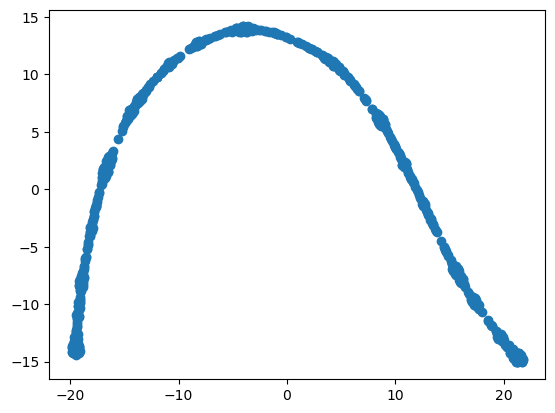

In [11]:
if __name__ == '__main__':
    main()